                                持买仓量
date       variety 持买仓量期货公司         
2018-10-22 A       海通期货       4115.0
           AG      海通期货      24758.0
           AL      海通期货       6832.0
           AP      海通期货       8181.0
           AU      海通期货       3649.0
           B       海通期货       2203.0
           BU      海通期货       6787.0
           C       海通期货       7346.0
           CF      海通期货       7164.0
           CU      海通期货       5686.0
           CY      海通期货         28.0
           FG      海通期货       5024.0
           FU      海通期货       2162.0
           HC      海通期货       6260.0
           I       海通期货      16098.0
           IC      海通期货       1568.0
           IF      海通期货       3798.0
           IH      海通期货       1088.0
           J       海通期货      15953.0
           JD      海通期货       1495.0
           JM      海通期货      12056.0
           L       海通期货       4363.0
           M       海通期货      22201.0
           MA      海通期货      43286.0
           NI      海通期货       5782.0
 

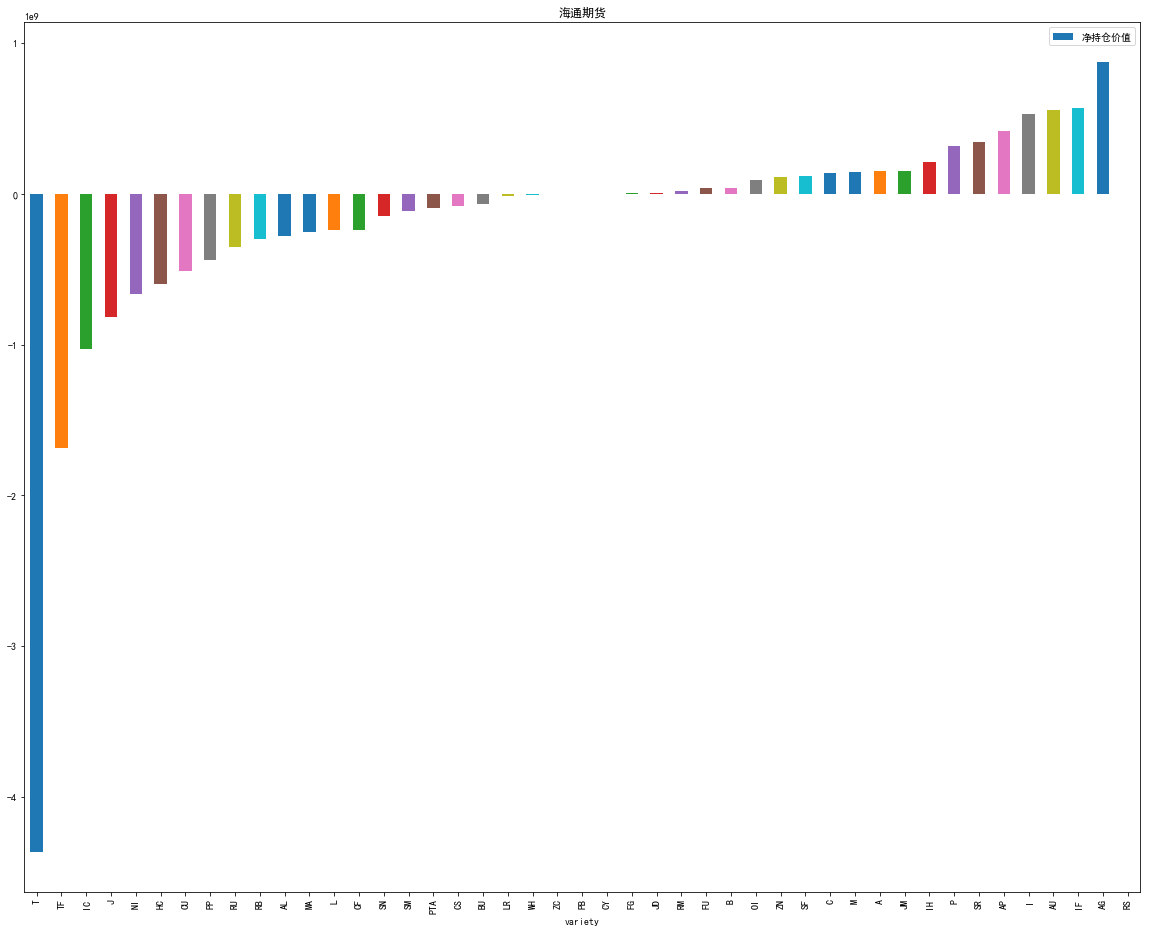

In [2]:
import pymongo
import pandas as pd
import matplotlib as plt
from pandas import Series,DataFrame
pd.set_option('display.width', None)  # 设置字符显示宽度
pd.set_option('display.max_rows', None)  # 设置显示最大行
pd.set_option('display.max_columns', None)  # 设置显示最大行

#连接数据库
client = pymongo.MongoClient('localhost',27017)
futures = client.futures


market = futures.market
unit = futures.unit
position = futures.position
#加载数据
market = DataFrame(list(market.find()))
unit = DataFrame(list(unit.find()))
position = DataFrame(list(position.find()))


# #类型转换
# market['set_close'] = market['set_close'].astype(float)
# unit['unit'] = unit['unit'].astype(float)

#大写字母
position['variety']=position['variety'].str.upper()

#删除/选取某行含有特殊数值的列
position=position.set_index('名次')

#选择需要显示的字段
data1=market[['date','variety','set_close']]

data2=unit[[ 'variety','unit']]
position=position[['date','variety','symbol','持买仓量期货公司','持买仓量', '持买仓量增减','持卖仓量期货公司','持卖仓量', '持卖仓量增减']]
# print(position.head())

#查询会员
members='海通期货'
data3=position[(position['持买仓量期货公司'] == members)]
#汇总合约
data3=data3[['date','variety','持买仓量期货公司','持买仓量']]
data3=data3.groupby(['date','variety','持买仓量期货公司'])[['持买仓量']].sum()
data4=position[(position['持卖仓量期货公司'] == members)]
# print(data4.head())
data4=data4[['date','variety','持卖仓量期货公司','持卖仓量']]
data4=data4.groupby(['date','variety','持卖仓量期货公司'])[['持卖仓量']].sum()
print(data3)
print(data4)
#并集
data5=pd.merge(data3,data4, on=['date','variety'],how='outer')
data5['会员简称']=data5.apply(lambda x: members,axis=1)
#nan缺失值填充fillna()为0
data5=data5.fillna(0)
data5['净持仓']=data5.apply(lambda x: x['持买仓量']-x['持卖仓量'],axis=1)
#选择需要显示的字段
data5=data5[['会员简称','持买仓量','持卖仓量','净持仓']]
data5=data5.reset_index(['variety','date'])
print(data5)

#合约价值
contractValue=pd.merge(data1,data2,how='left',sort=False).drop_duplicates()
contractValue['contractValue'] = contractValue.apply(lambda x: x['set_close']*x['unit'],axis=1)
contractValue=contractValue[['date','variety','contractValue']]
#值替换replace()
contractValue=contractValue.replace(['TA'],'PTA')
print(contractValue)
# contractValue.set_index(['date','variety'], inplace = True)
sz=pd.merge(data5,contractValue,on=['date','variety'],how='left')
#净持仓价值
sz['净持仓价值']=sz.apply(lambda x: x['净持仓']*x['contractValue'],axis=1)
sz=sz[['date','variety','净持仓价值']]
sz=sz.sort_values(by='净持仓价值')
print(sz)
sz.plot.bar(x='variety',y='净持仓价值',figsize=(20,16),title=members)
print(sz['净持仓价值'].sum())


#二行即可搞定画图中文乱码
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
